# Amazon Stock Price Prediction: Time Series Analysis and Forecasting

A time series is data recorded at periodic time intervals. Time Series Analysis is used to gain insight from time-series data and make useful predictions. It helps us understand and compute the probability of an incident. Founded in 1994, Amazon is an American technology company known for its e-commerce services, among others. This project aims carry out time series analysis and forecasting of Amazon Stock prices.

**Dataset**: The dataset leveraged includes stock prices from May 1997 to July 2022. [Link: https://www.kaggle.com/datasets/aayushkandpal/amazon-stock-data-15051997-2009-2020/data].

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Amazon.csv', parse_dates=['Date'])
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


#### Features:
* **Open:** The open is the starting period of trading on a securities exchange or organized over-the-counter market.
* **High:** The high is the highest price at which a stock traded during the course of the trading day and is typically higher than the open value.
* **Low:** The low is typically lower than the opening or closing price, the lowest price of the day.
* **Close:** The close is the closing price generally refers to the last price at which a stock trades during a regular trading session.
* **Adj Close:** The adjusted closing price amends a stock's closing price to reflect that stock's value after external factors are accounted for.
* **Volume:** The volume denotes the sum amount of stocks that have been bought within a given time period.

In this project we will explore the Open value.

In [3]:
data = data[['Date','Open']]

Ideally, the data should be in chronological order. This can be achieved as follows:

In [4]:
data.sort_index(inplace=True)

The time interval in the time series should be equal for each entry. As some days are missing in our data, we will downsample and group days into weeks.

In [5]:
data_downsampled = data[['Date','Open']].resample('7D', on='Date').mean().reset_index(drop=False)
data_downsampled['Open'] = data[['Date','Open']].resample('7D', on='Date').sum().reset_index(drop=False)[['Open']]
data = data_downsampled
data.set_index('Date', inplace=True)

### Handling Missing Values

In [6]:
data.isnull().sum()

Open    0
dtype: int64

### Handling Duplicate Values
Because the data should have unique dates per row, we are only concerned with the date index being unique for all entries.

In [7]:
data.index.duplicated().sum()

0

## Data Exploration
### Components of a Time Series
* **Trend:** The linear movement of the time-series. It may be increasing, decreasing or neutral and can be identified by the slope over time.
* **Seasonality:** A pattern that repeats over a set period of time e.g. yearly, seasonally. An example is increased energy consumption over summer and winter. It occurs at the same frequency.
* **Cyclicality:** Also a pattern that repeats, however it occurs with irregular frequency or over a large time interval.
* **Noise:** Random occurences in data. It exists if and only if there is no correlation between the features and is typically removed for smoother forecasting.


### Stationarity
A stationary time series has a constant mean and other statistics, e.g. variance and standard deviation, over time. Some time series models work on the assumption that the data is stationary. 

There are three types of stationarity in time-series:
1. **Trend Stationary:** Such a time series has no trend component.
2. **Seasonality Stationary:** Such a time series has no seasonality component.
3. **Strictly Stationaty:** Such a time-series has insignificantly little shifts in its statistics.

Therefore, we will be investigating the stationarity of the data using three techniques: (1) visualization, (2) rolling statistics, and (3) Dickey Fuller test.

#### Visualization
Let us start by plotting the time series.

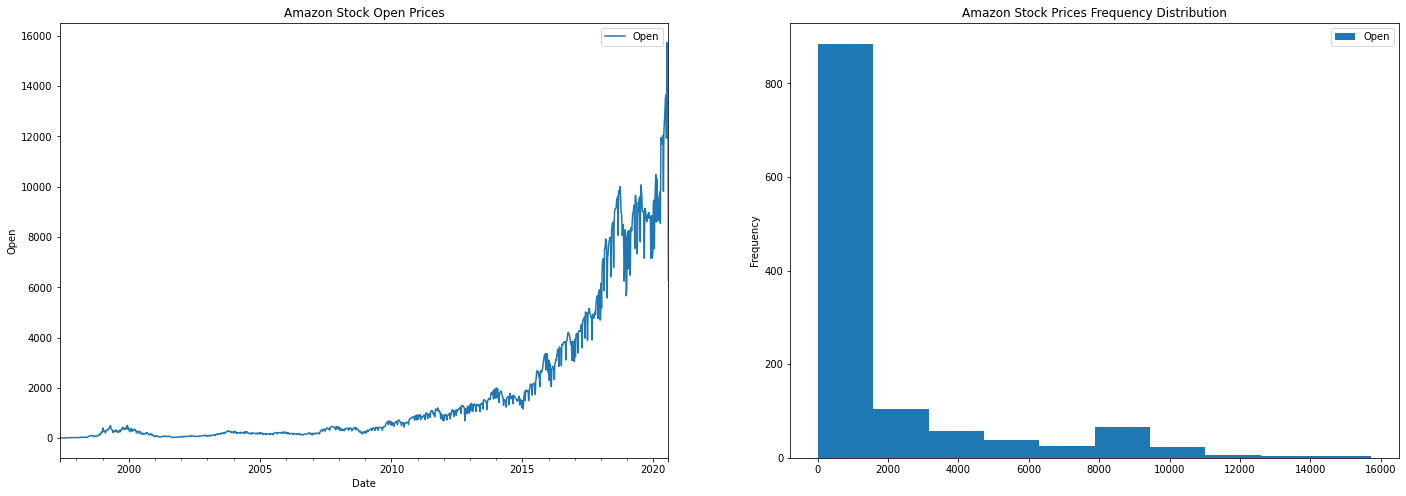

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
fig.subplots_adjust(wspace=0.2)
data.plot(ax=axes[0], title='Amazon Stock Open Prices', ylabel='Open')
data.plot(ax=axes[1], kind="hist", title='Amazon Stock Prices Frequency Distribution')
plt.show()

It is easy to see that the time series in non-stationary. Our target feature has a rising trend. Another chart that explains the stationarity is a histogram. It is apparent that the distribution is heavily **skewed to the left**. A stationary time series would a more normal distribution. Next, let us check the statistics of the data.

We can further investigate this by checking the rolling statistics.

#### Moving Average and Rolling Statistics

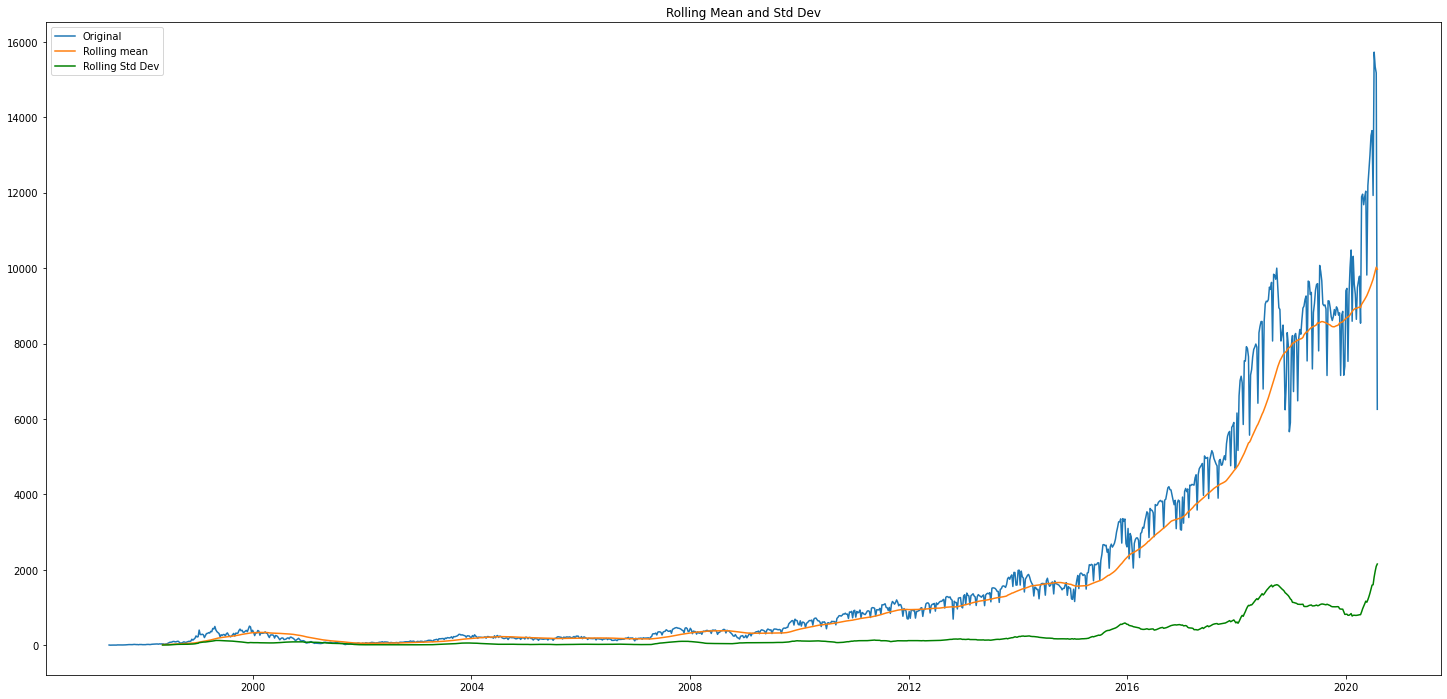

In [107]:
def test_stationarity(df):
    rolling_window = df.rolling(window=52) #window takes the averge over a year
    roll_mean = rolling_window.mean() 
    roll_std = rolling_window.std()

    #plot rolling stats
    plt.figure(figsize=(25,12))
    orig = plt.plot(df, label='Original')
    mean = plt.plot(roll_mean, label='Rolling mean')
    std = plt.plot(roll_std, color='green', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std Dev')
    plt.show()

test_stationarity(data)

#### Dickey Fuller Test
The Dickey Fuller test is a hypothesis testing experiment used to verify the stationarity of data. It is carried out under the following assumptions:
* Null Hypothesis (H0): Series is non-stationary
* Alternate Hypothesis (H1): Series is stationary
* If the p-value > 0.05 Accept H0
* Else, if the p-value <= 0.05 Accept H1

In [108]:
#perform adf test
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df):
    print('Dickey Fuller Test Results:\n')
    test_df = adfuller(df, autolag='AIC')
    output_df = pd.Series(test_df[0:4], index=['Test Statistic','p-value','#Lags Used','#Observations Used'])
    for key,value in test_df[4].items():
        output_df['Critical Value (%s)'%key] = value
    print(output_df)

adfuller_test(data)

Dickey Fuller Test Results:

Test Statistic             3.655117
p-value                    1.000000
#Lags Used                23.000000
#Observations Used      1188.000000
Critical Value (1%)       -3.435866
Critical Value (5%)       -2.863976
Critical Value (10%)      -2.568067
dtype: float64


Here, our p-value is 1.00 which is much greater than our critical value of 0.05. Therefore, we accept the Null Hpothesis and say that the series is non-stationary.

### Making the Time Series Stationary
The presence of trend and seasonality in a time series makes it non-stationarity. Therefore, eliminating these components makes it stationary.

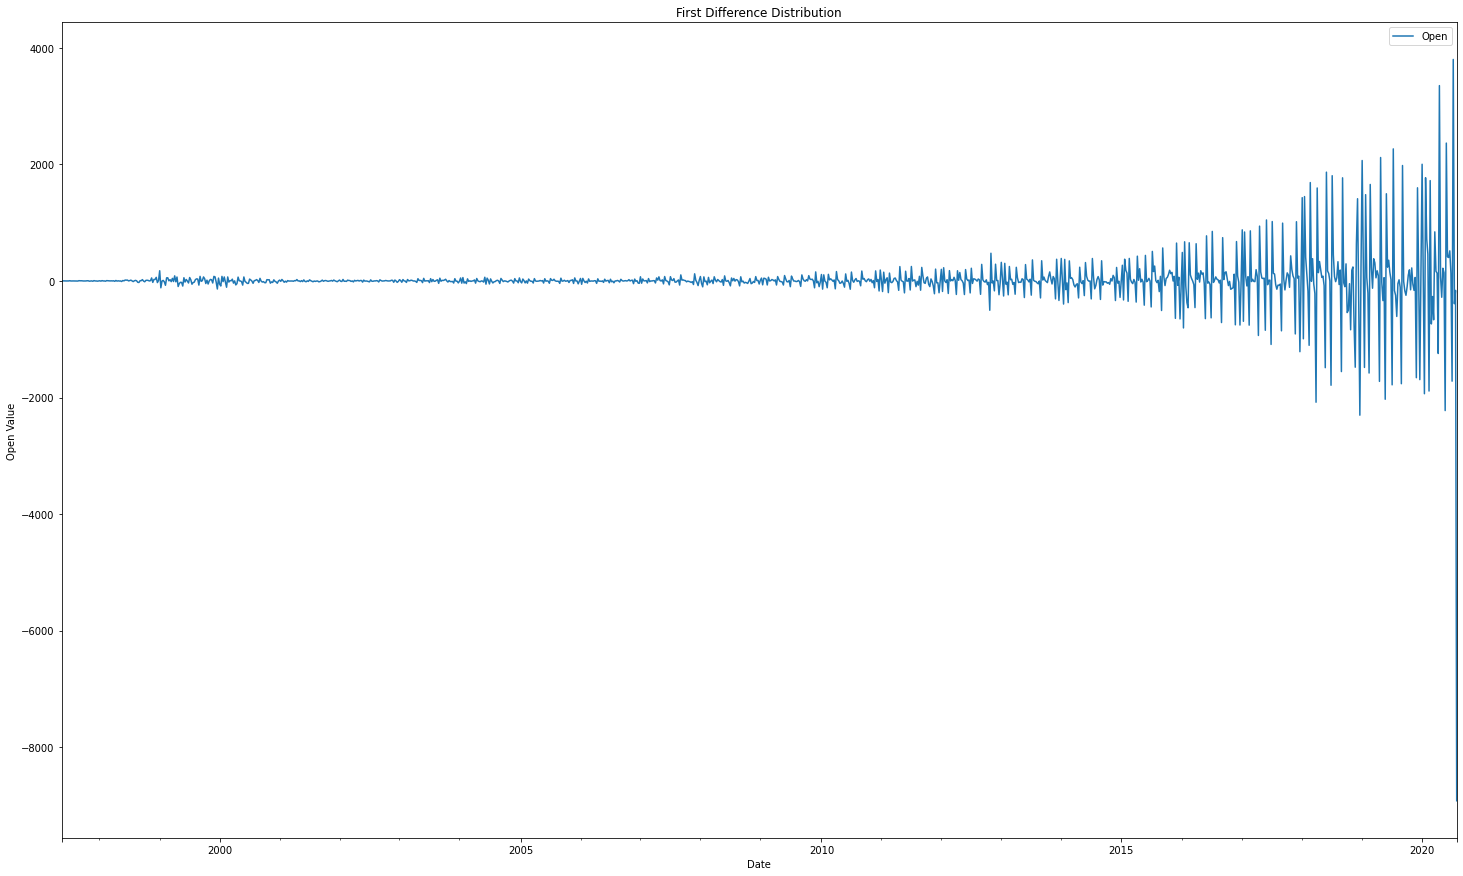

In [11]:
data_diff = data.diff().dropna()
data_diff.plot(figsize=(25,15), title='First Difference Distribution', ylabel='Open Value')
plt.show()

The distribution shows a significant removal of the trend. Visualize the rolling mean and the Dickey Fuller test to further verify the results.

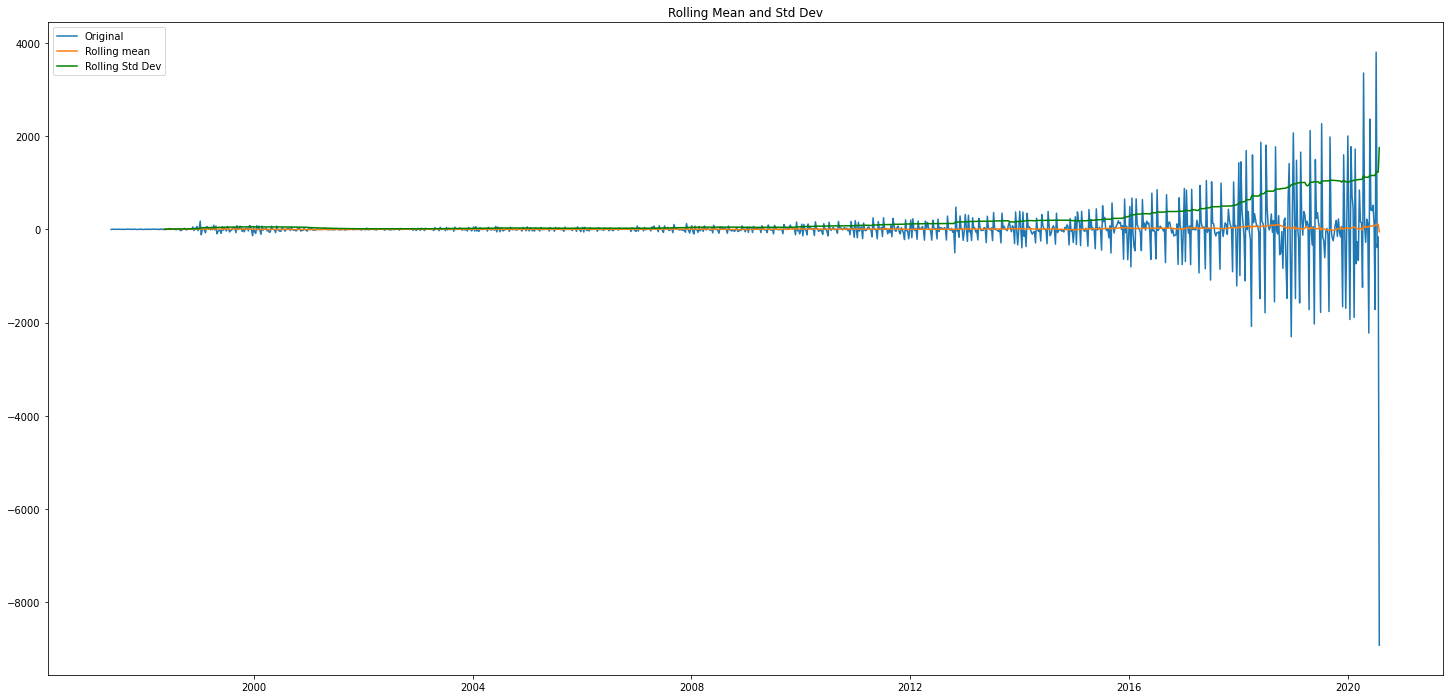

Dickey Fuller Test Results:

Test Statistic         -6.855039e+00
p-value                 1.656740e-09
#Lags Used              2.300000e+01
#Observations Used      1.187000e+03
Critical Value (1%)    -3.435871e+00
Critical Value (5%)    -2.863978e+00
Critical Value (10%)   -2.568068e+00
dtype: float64


In [109]:
test_stationarity(data_diff)
adfuller_test(data_diff)

The p-value is a lot less than the critical value, so removing the trend is a success. For even more intricate details, we will decompose the time series into its components.

#### Seasonal Decomposition
While differencing successfully removes the trend in the data, the seasonality remains. In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

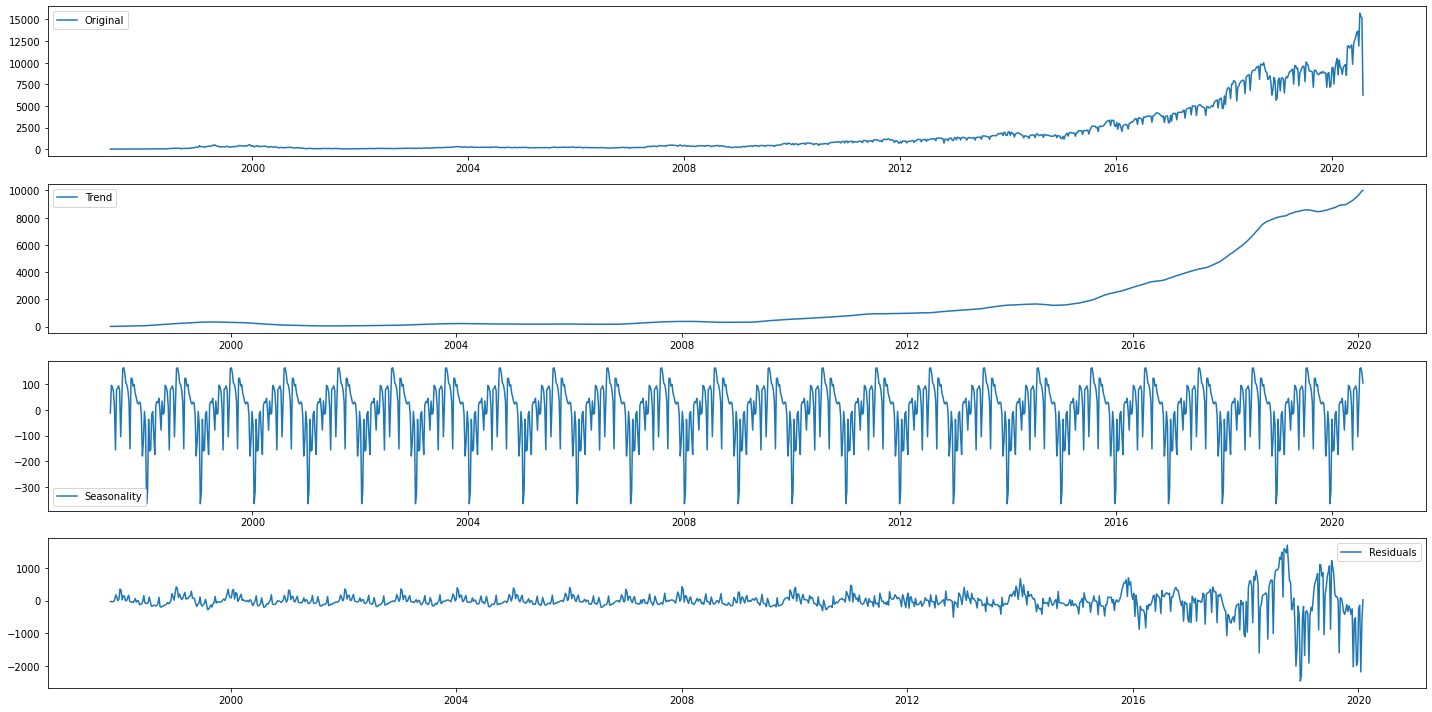

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

Dickey Fuller test on the residual to test stationarity.

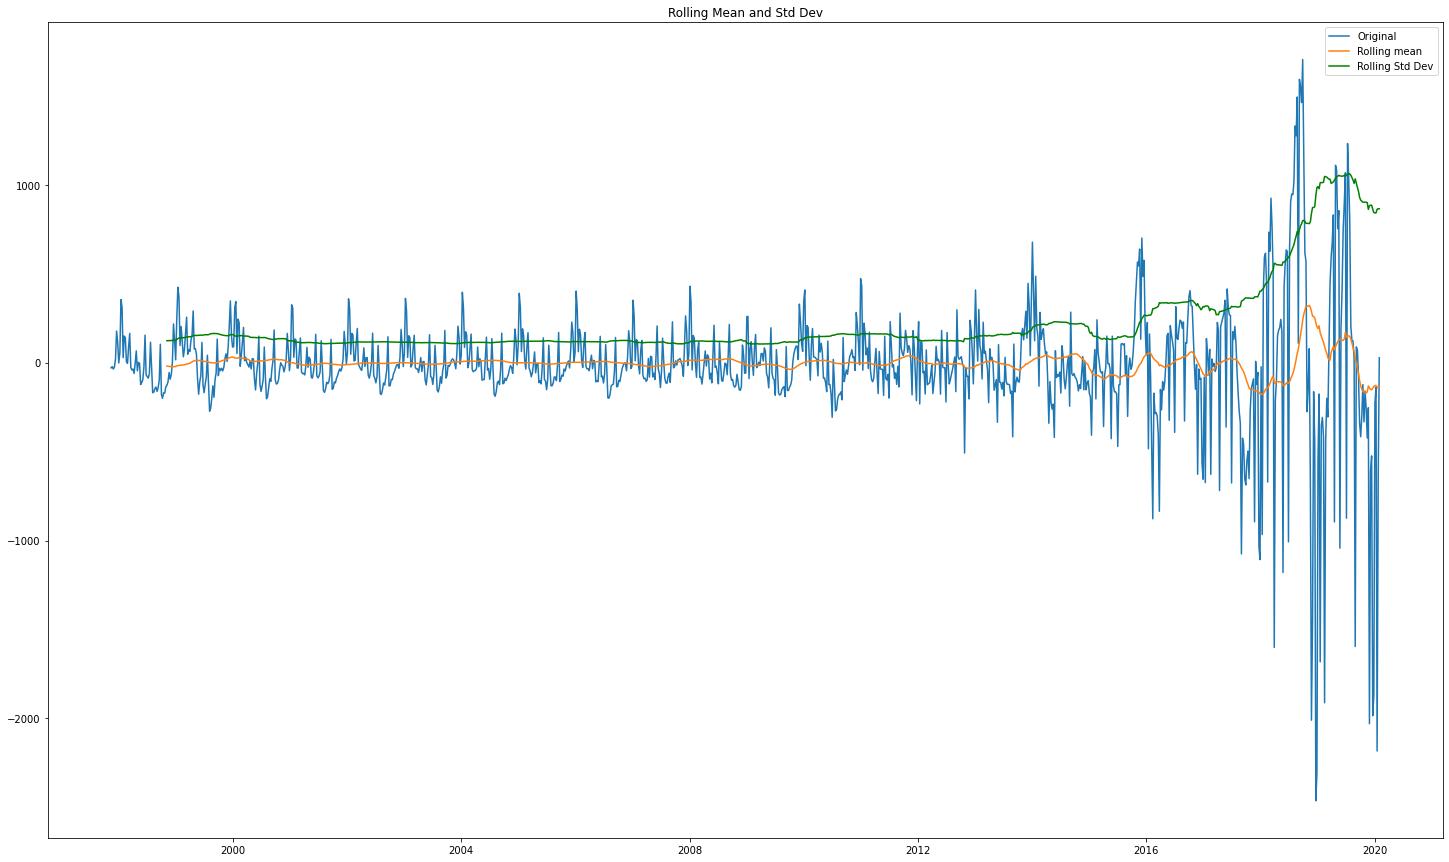

Dickey Fuller Test Results:

Test Statistic         -8.346613e+00
p-value                 3.073247e-13
#Lags Used              2.300000e+01
#Observations Used      1.136000e+03
Critical Value (1%)    -3.436119e+00
Critical Value (5%)    -2.864088e+00
Critical Value (10%)   -2.568126e+00
dtype: float64


In [14]:
data_resid = residual
data_resid.replace([np.inf, -np.inf], np.nan, inplace=True)
data_resid.dropna(inplace=True)
test_stationarity(residual)
adfuller_test(residual)

We notice a slow decay in the correlation as we move further into the past. For our model, let us consider 100 lags.

## Train-Test Split

In [15]:
split_size = int(data.shape[0]*0.85) #train set is 85% of the original data
train_data = data.iloc[:split_size]
test_data = data.iloc[split_size:]

#time periods of the training and testing datasets
print('Train set: %s to %s' % (train_data.index.min().date(), train_data.index.max().date()))
print('Test set: %s to %s' % (test_data.index.min().date(), test_data.index.max().date()))

Train set: 1997-05-15 to 2017-02-02
Test set: 2017-02-09 to 2020-07-30


## Forecasting Models 
### ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. It is a popular time series forecasting model that performs linear regression on data in order to make predictions for the future. The ARIMA model is based on the assumption that a time series is stationary, therefore for this example, we will use differenced data from before (See ). 

There are three important parameters to note when using the ARIMA model:
* **p** - The number of auto-regressive lags used for forecasting.
* **d** - The number of order differeces. For example, we took the first order difference and can set q=0. However, if the first order difference was not taken, we will pass the original data and set q=1. Similarly, we use q=2 if we want the second order difference and so on.
* **q** - Size of the moving average window.

To set p and q, the autocorrelation function and partial autocorrelation function are leveraged.

### Autocorrelation and Partial Autocorrelation Function Plots

To understand the correlation between the current timestamp, *t*, and previous timestamps, *t-1*, *t-2*, ..., *t-n*, the autocorrelation function (ACF) and partial autocorrelation function (PACF) are used.

- **ACF:** Checks randomness by measuring the correlation between the time series and lagged versions of itself.
- **PACF:**  It is similar to ACF except it removes any correlations that exist due to dependence between intermediate lags.

To summarize, the correlation values vary in the range of [-1,1] where a value of 0 indicates no correlation.


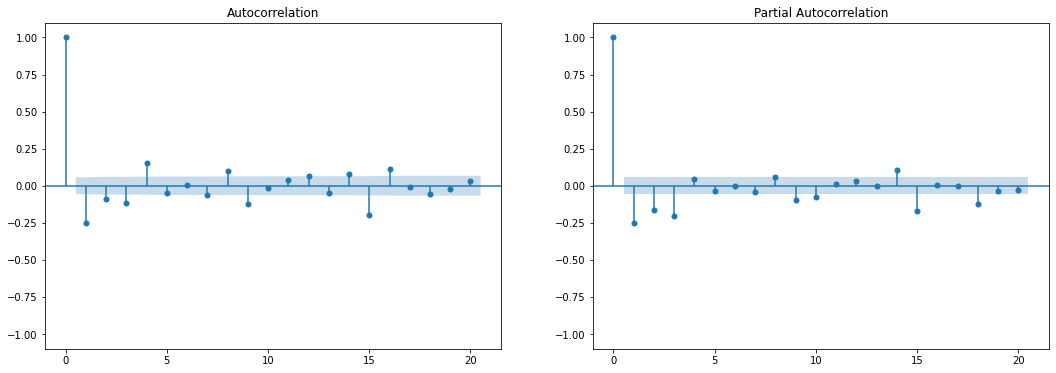

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=2)
plot_acf(data_diff['Open'], ax=ax[0], lags=20)
plot_pacf(data_diff['Open'], ax=ax[1], lags=20)
ax[0].set_ylim(-1.1,1.1)
ax[1].set_ylim(-1.1,1.1)
plt.show()

The plots above depict the ACF and PACF plots for the stationary (1st order differenced) time series. Only the later is considered to set the parameters.

#### The Choice for *p*
The PACF plot shows that the first three lags are significant so p=3.
#### The Choice for *d*
From the differencing exercise earlier, it has been established that the first order difference results in a stationary time series so d=1 is sufficient.
#### The Choice for *q*
The ACF plot indicates that upto the first four lags are significant; as a result q=4.

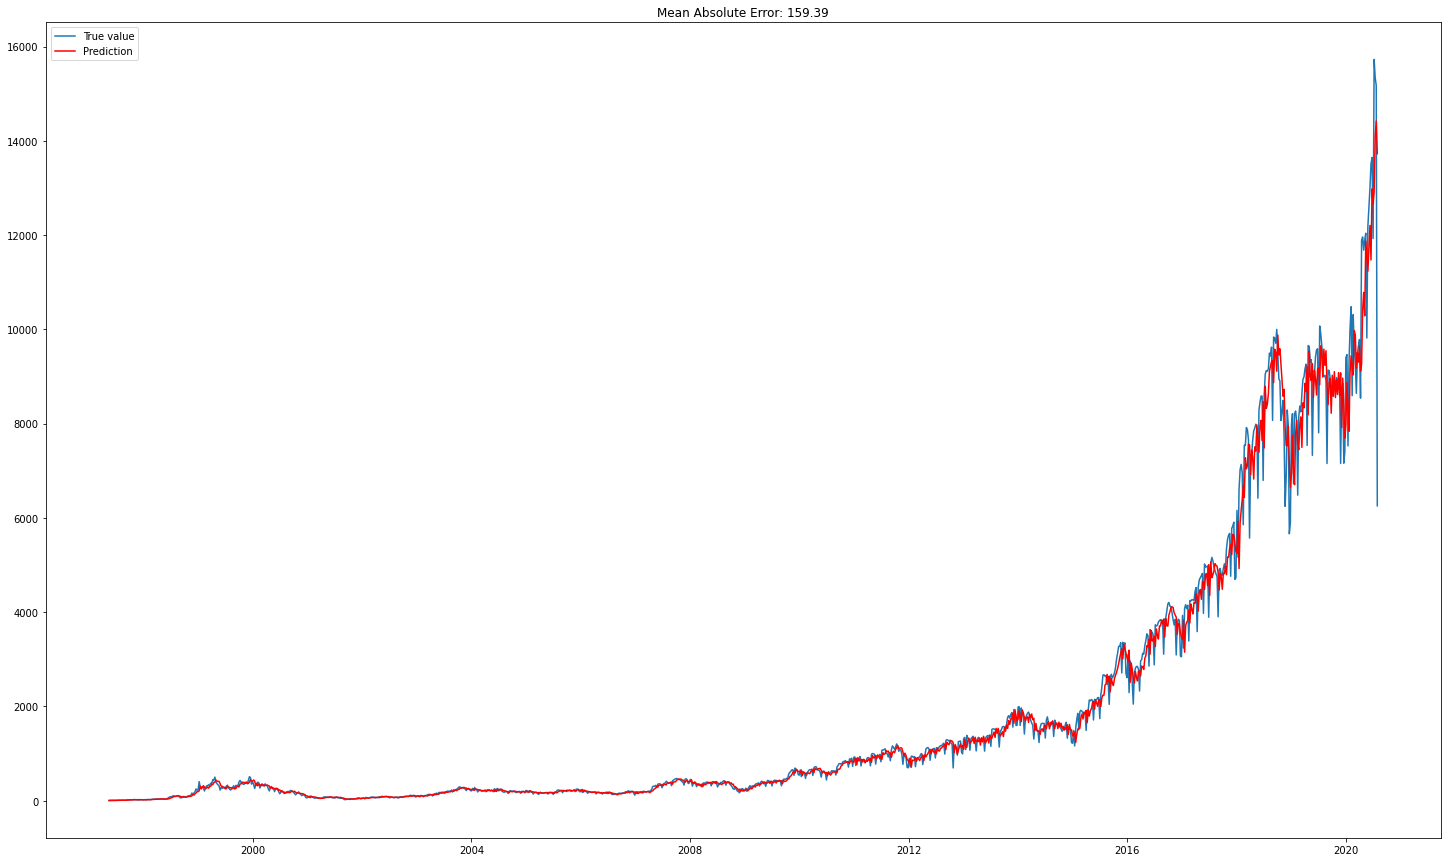

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = ARIMA(data['Open'], order=(3,1,4))
model_fit = model.fit()
plt.figure(figsize=(25,15))
plt.plot(data['Open'], label='True value')
plt.plot(model_fit.fittedvalues, color='red', label='Prediction')
plt.title('Mean Absolute Error: %.2f' % (mean_absolute_error(data['Open'].values, model_fit.fittedvalues.to_numpy())))
plt.legend()
plt.show()

From the above example, we observed how well the ARIMA model estimates the time series. In order to see how accurate the ARIMA model is at predicting the future, we will run a few experiments using training (seen) data and test (new) data.

#### Method 1: Making Predictions without Updating the trained Model

In [18]:
# helper function to plot predictions
def plot_preds(predictions):
    df = test_data.copy()
    df['Predictions'] = np.array(predictions)
    mae = round(mean_absolute_error(df['Open'], df['Predictions']),2)
    df['Open'].plot(label='True value', figsize=(25,9), title="MAE:"+str(mae))
    df['Predictions'].plot(label='Prediction')
    plt.legend()
    plt.show()

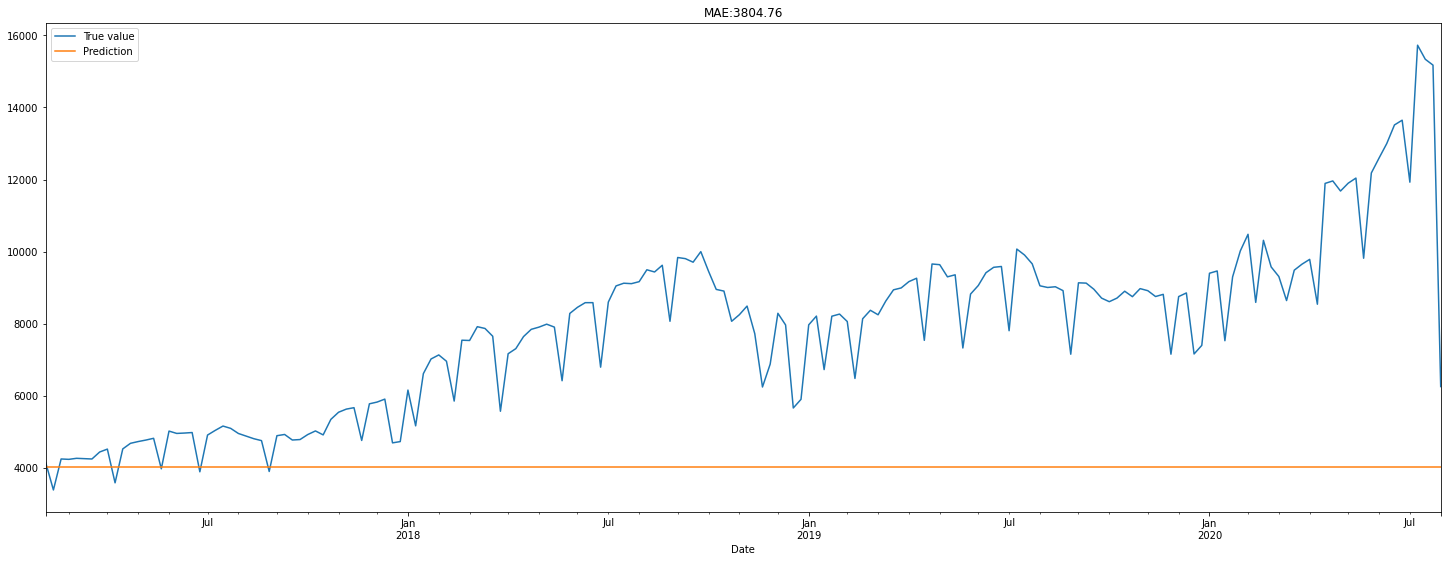

In [23]:
model = ARIMA(train_data.values.flatten(), order=(3,1,4))
model_fit = model.fit()
predictions = []

for i in range(test_data.shape[0]):
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
plot_preds(predictions)

The model predicts the same value continuously for all weeks. Therefore, we need to update the trained model for each prediction that is made.

#### Method 2: Making Predictions by Updating the Model with Predicted Values

0.0% complete
27.47% complete
54.95% complete
82.42% complete
100% complete


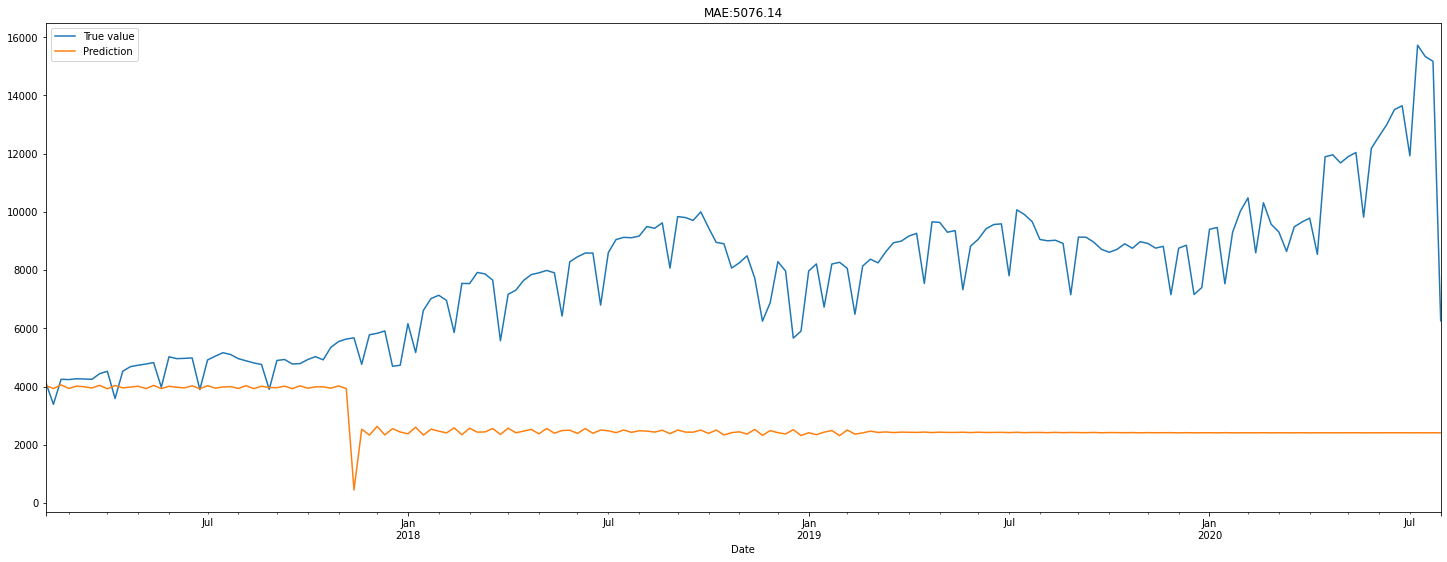

In [24]:
predictions = []
history = train_data.values.flatten()

for i in range(test_data.shape[0]):
    model = ARIMA(history, order=(3,1,4))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    history = np.append(history, [y_pred])
    
    if i%50 == 0:
        per = round(i/test_data.shape[0] * 100, 2)
        print(f'{per}% complete')
print('100% complete')

plot_preds(predictions)

Although it is slight, there is some variation in the values predicted by the model comparison to the values in the previous experiment. However, similar to not updating the model, the forecasted values based on past predictions made by the ARIMA model end up flatlining at a specific value.

#### Method 3: Making Predictions by Updating the Model with True Values

0.0% complete
27.47% complete
54.95% complete
82.42% complete
100% complete


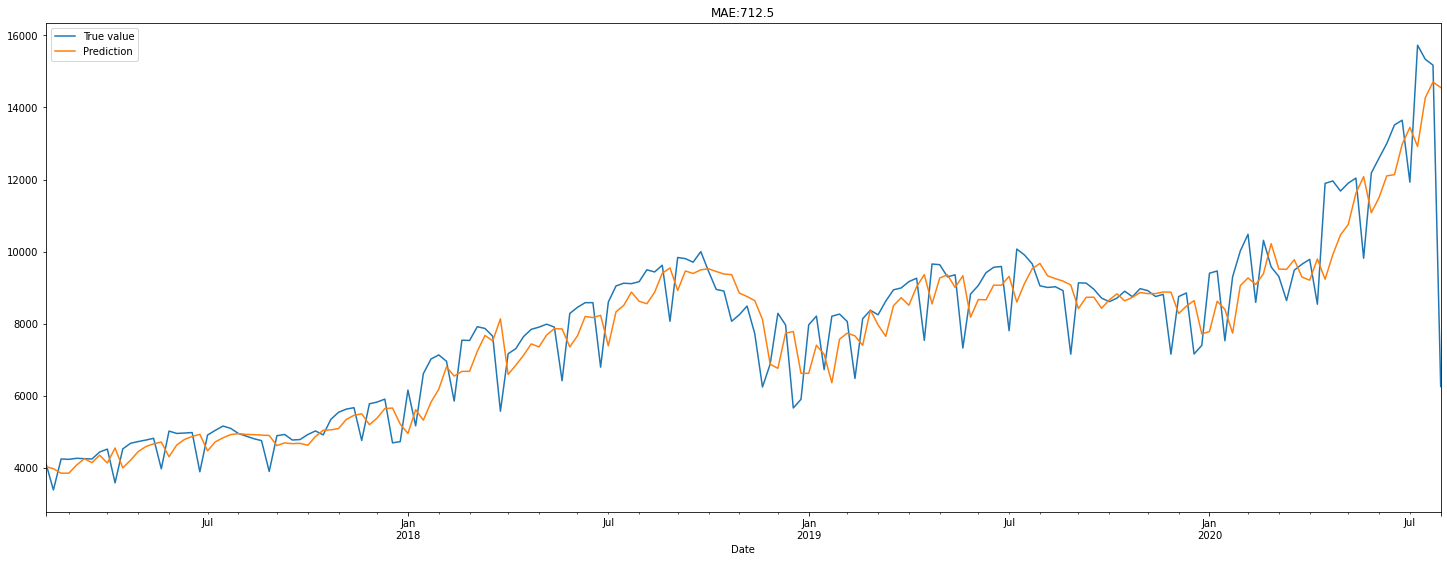

In [25]:
predictions = []
for i in range(test_data.shape[0]):
    history = data['Open'].iloc[:split_size+i]
    model = ARIMA(history, order=(3,1,4))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    
    if i%50 == 0:
        per = round(i/test_data.shape[0] * 100, 2)
        print(f'{per}% complete')
print('100% complete')

plot_preds(predictions)

Of the 3 models tested, this model shows the best performance with the lowest MAE score. As illustrated by the plot, the forecast is much closer to the actual outcome. 

### LSTMs

Long Short Term Memory networks (LSTMs) are a variant of recurrent neural networks which are capable of learning long-range patterns.

#### Feature Engineering

In this section we will create some features to train our forecast model on. As LSTMs are a supervised learning model we require both input features, ***X***, and output values, ***y***. In the case of time series forecasting, the input features will be previous time stamps up until *t-1*, and the output will be the value of the current timestamp *t* as we traverse through the data. As the data is represented on a weekly bases, we use a look back window of 4 to consider the performance of the stock within the past month.

In [46]:
def create_seq_features(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        seq = data[i-look_back:i, 0]
        X.append(seq)
        y.append(data[i])
    return np.array(X), np.array(y)

For more accurate forecasting, we consider the stock prices only within six years, between July 2014 and July 2020.

In [103]:
# take the values of first order difference of the data
lstm_data = data.loc[data.index >= '2014-07-01']

# rolling window size
look_back = 4

# train-test split
split_size = int(len(lstm_data)*0.85)

lstm_train = lstm_data[:split_size]
lstm_test = lstm_data[split_size-look_back:] # we include the last four features from the train set to avoid losing information in sequence extraction

#### Scaling the Data
As with other machine learning models, LSTMs perform better when the input features are scaled within a small range. Our LSTM layers will use a sigmoid function, therefore the features are scaled down to the range [0.0,1.0] before being used to train the network and make predictions with it. 

In [94]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.0,1.0))

scaler.fit(lstm_data)

lstm_train_scaled = scaler.transform(lstm_train.values)
lstm_test_scaled = scaler.transform(lstm_test.values)

Now extract the features.

In [95]:
X_train, y_train = create_seq_features(lstm_train_scaled, look_back)
X_test, y_test = create_seq_features(lstm_test_scaled, look_back)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape, X_test.shape)

(266, 1, 4) (48, 1, 4)


### LSTM Model
We are ready to design the model and train it. We leverage the Tensorflow library to build our model. The input shape to the LSTM must be in the form (num_samples, num_timesteps, num_features).

In [96]:
import tensorflow as tf

ep, bs = 10, 1 

#define the model
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2]))) # (num_samples, num_timesteps, num_features).
lstm_model.add(tf.keras.layers.LSTM(32,  return_sequences=False))
lstm_model.add(tf.keras.layers.Dense(16)) 
lstm_model.add(tf.keras.layers.Dense(1)) # only one node is required for output as the desired about is a single regression value

lstm_model.compile(loss='mean_absolute_error', optimizer='adam')

#fitting the model
lstm_model.fit(X_train, y_train, epochs=ep, batch_size=bs, verbose=1, shuffle=False, validation_data=(X_test, y_test)) #set shuffle to false to ensure the data is fed sequentially

lstm_model.summary()

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0211 - val_loss: 0.1001
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1075 - val_loss: 0.1023
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1369 - val_loss: 0.0931
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1022 - val_loss: 0.0905
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0951 - val_loss: 0.0945
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0905 - val_loss: 0.0920
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0756 - val_loss: 0.0917
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0592 - val_loss: 0.0924
Epoch 9/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0444 - val_loss: 0.0941
Epoch 10/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0484 - val_loss: 0.0943


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,877 (358.90 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,252 (239.27 KB)

In [ ]:
# make predictions
train_preds = lstm_model.predict(X_train, verbose=0)
test_preds = lstm_model.predict(X_test, verbose=0)

#rescale predictions to original range
train_preds = scaler.inverse_transform(train_preds)
y_train = scaler.inverse_transform(y_train)
test_preds = scaler.inverse_transform(test_preds)
y_test = scaler.inverse_transform(y_test)

# get mae and rmse
train_mae = round(mean_absolute_error(y_train, train_preds), 2)
test_mae = round(mean_absolute_error(y_test, test_preds), 2)
train_rmse = round(mean_squared_error(y_train, train_preds), 2)
test_rmse = round(mean_squared_error(y_test, test_preds), 2)

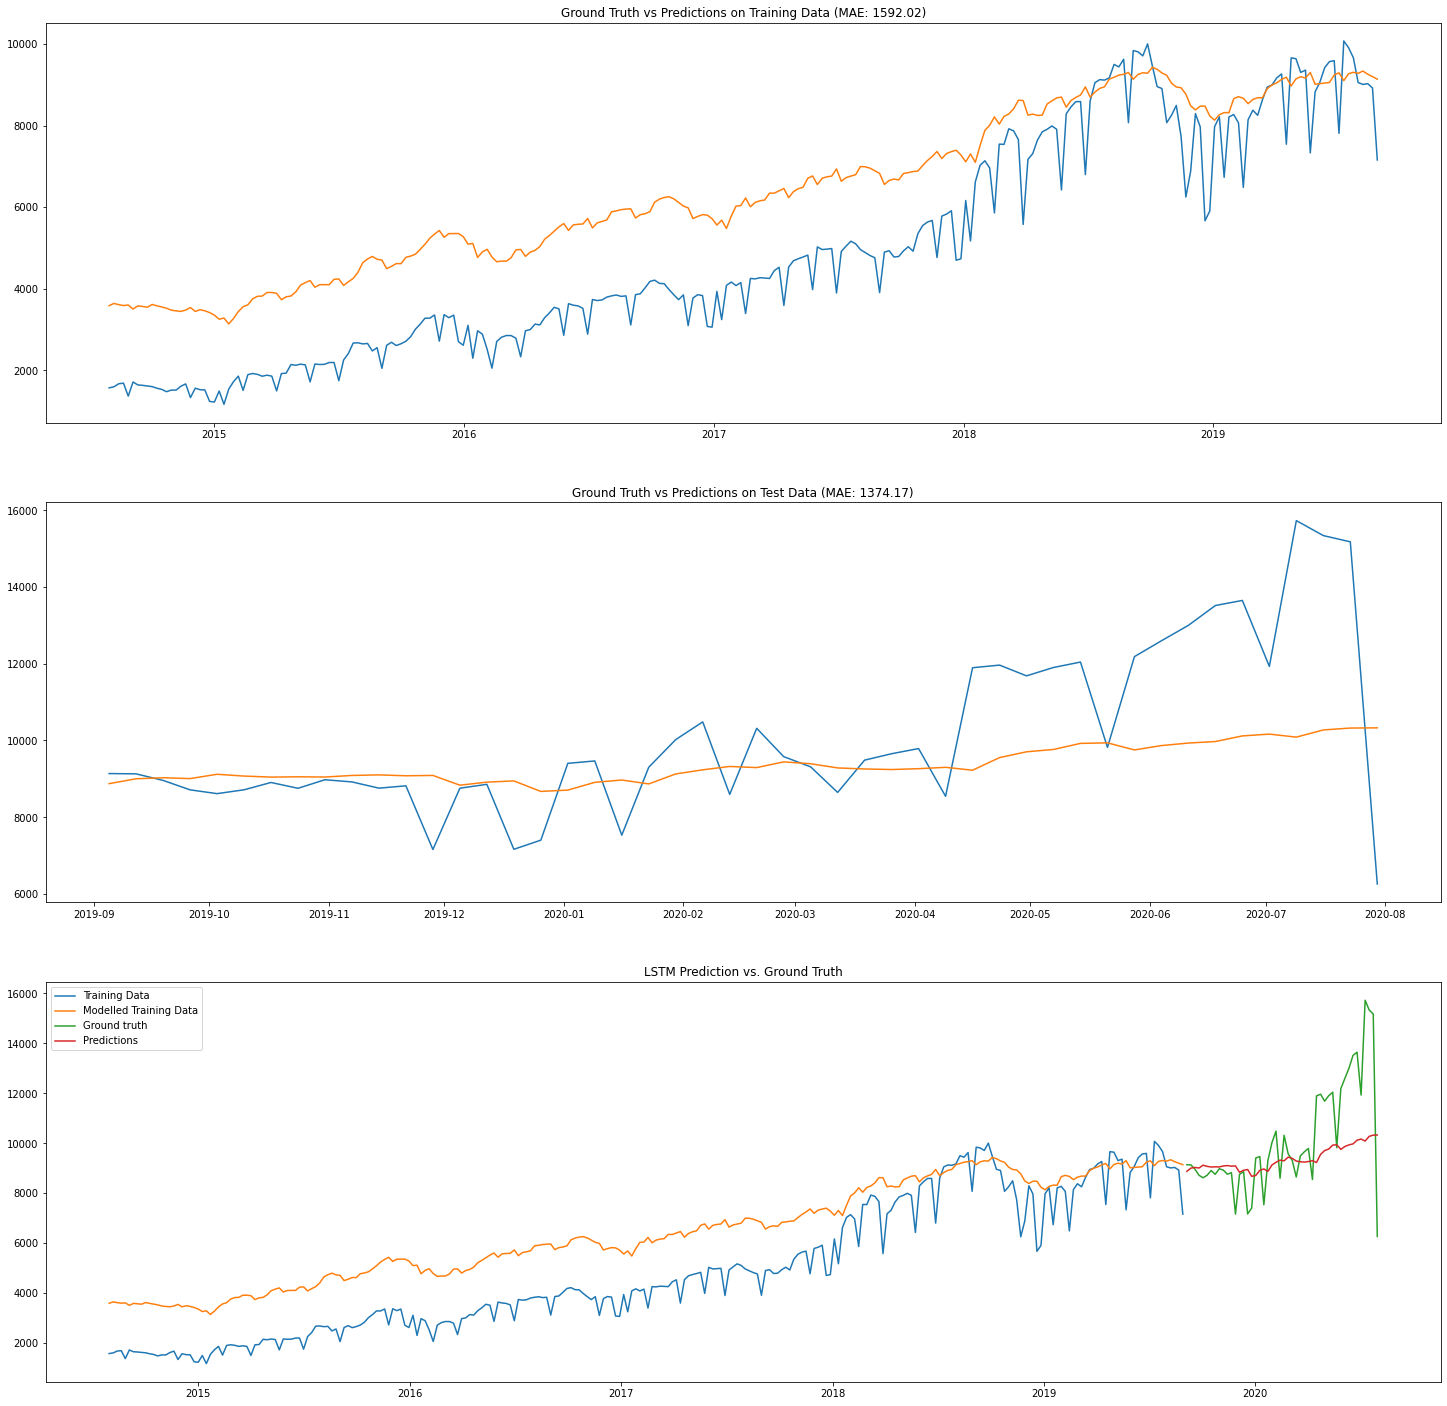

In [102]:
# add date time indices to predictions
idx_train = lstm_train[look_back:].index
y_train = pd.DataFrame(y_train, index=idx_train)
train_preds = pd.DataFrame(train_preds, index=idx_train)

idx_test = lstm_test[look_back:].index
y_test = pd.DataFrame(y_test, index=idx_test)
test_preds = pd.DataFrame(test_preds, index=idx_test)

#plot the results
plt.figure(figsize=(25,25))

plt.subplot(311)
plt.plot(y_train)
plt.plot(train_preds)
plt.title('Ground Truth vs Predictions on Training Data (MAE: ' + str(train_mae) + ')')

plt.subplot(312)
plt.plot(y_test)
plt.plot(test_preds)
plt.title('Ground Truth vs Predictions on Test Data (MAE: ' + str(test_mae) + ')')

plt.subplot(313)
plt.plot(y_train, label='Training Data')
plt.plot(train_preds, label='Modelled Training Data')
plt.plot(y_test, label='Ground truth')
plt.plot(test_preds, label='Predictions')
plt.legend()
plt.title('LSTM Prediction vs. Ground Truth')

plt.show()

Obviously, we have only tried one configuration for the LSTM. There are other methods to make predictions using LSTMs. Here we have make fixed predictions where the model was not updated when new observations were made. If the model were to be retrained each time a new observation was made perhaps there could be a significant improvement in performance, as was seen with the ARIMA model. However we will not be covering that here.

## Conclusion
In this project we performed time-series analysis on Amazon Stock Prices and attempted to make accurate forecasts using a traditional ARIMA model and deep learning LSTM model. Although many facets of Time Series Analysis have been discussed, there are still aspects that have not been touched on, including Multivarite Time Series Analysis where multiple features are explored to make forecasts. Further, other models such as the SARIMAX, a variant of ARIMA, and Prophet, a multivariate model, exist to boost forecasting outcomes. Methods of conducting stationarity tests e.g. the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test and making a non-stationary time series using transformation have not been covered.

#### Resources
* https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost
* https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook
* https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/#h-how-to-check-the-stationarity-of-a-time-series
* https://www.analyticsvidhya.com/blog/2022/05/a-comprehensive-guide-to-time-series-analysis-and-forecasting/
* https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting#Models